In [97]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('whitegrid')

In [96]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 547.6 kB/s eta 0:00:00m eta 0:00:010:00:01


In [20]:
data = pd.read_csv('./multipleChoiceResponses.csv')

/tmp/ipykernel_15556/1704529858.py:1: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./multipleChoiceResponses.csv')


In [7]:
data.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


In [10]:
print("Number of people participated in this survey are :", len(data))
print("Columns are :", data.columns)

Number of people participated in this survey are : 23860
Columns are : Index(['Time from Start to Finish (seconds)', 'Q1', 'Q1_OTHER_TEXT', 'Q2',
       'Q3', 'Q4', 'Q5', 'Q6', 'Q6_OTHER_TEXT', 'Q7',
       ...
       'Q49_OTHER_TEXT', 'Q50_Part_1', 'Q50_Part_2', 'Q50_Part_3',
       'Q50_Part_4', 'Q50_Part_5', 'Q50_Part_6', 'Q50_Part_7', 'Q50_Part_8',
       'Q50_OTHER_TEXT'],
      dtype='object', length=395)



## Analysing the income of the respondents




In [15]:
data.iloc[1]

Time from Start to Finish (seconds)                         710
Q1                                                       Female
Q1_OTHER_TEXT                                                -1
Q2                                                        45-49
Q3                                     United States of America
                                                 ...           
Q50_Part_5                                                  NaN
Q50_Part_6                                                  NaN
Q50_Part_7                                                  NaN
Q50_Part_8                                                  NaN
Q50_OTHER_TEXT                                               -1
Name: 1, Length: 395, dtype: object

In [21]:
question_names = data.iloc[0]
data = data.drop(0, axis=0) # removing the row of questions

In [23]:
print(question_names['Q9'])
print(data["Q9"].unique())

data = data[data['Q9'].notnull()]
data = data[data['Q9'] != 'I do not wish to disclose my approximate yearly compensation']
print(data["Q9"].unique())

What is your current yearly compensation (approximate $USD)?
[nan '10-20,000' '0-10,000'
 'I do not wish to disclose my approximate yearly compensation'
 '20-30,000' '125-150,000' '30-40,000' '50-60,000' '100-125,000'
 '90-100,000' '70-80,000' '80-90,000' '60-70,000' '400-500,000'
 '40-50,000' '150-200,000' '500,000+' '300-400,000' '200-250,000'
 '250-300,000']
['10-20,000' '0-10,000' '20-30,000' '125-150,000' '30-40,000' '50-60,000'
 '100-125,000' '90-100,000' '70-80,000' '80-90,000' '60-70,000'
 '400-500,000' '40-50,000' '150-200,000' '500,000+' '300-400,000'
 '200-250,000' '250-300,000']


In [24]:
print("Replies left after removing non numeric values are", len(data))

Replies left after removing non numeric values are 15429


### Distribution of yearly income

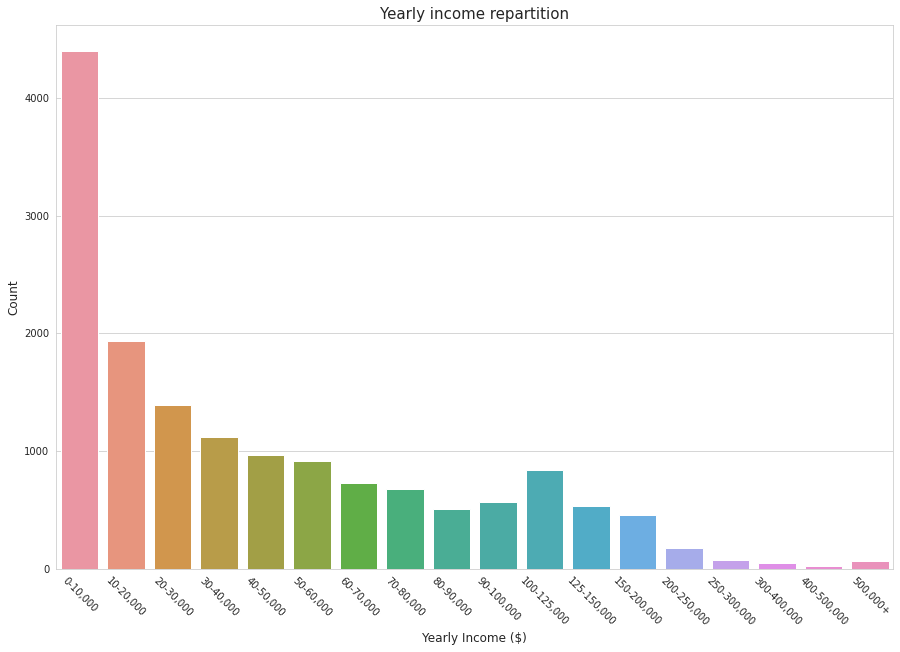

In [46]:
order = ['0-10,000', '10-20,000', '20-30,000', '30-40,000', '40-50,000', 
  '50-60,000', '60-70,000', '70-80,000', '80-90,000', '90-100,000', 
  '100-125,000', '125-150,000', '150-200,000', '200-250,000', '250-300,000', 
  '300-400,000', '400-500,000', '500,000+']

plt.figure(figsize=(15,10))
sns.countplot(x ='Q9', data = data, order=order)
plt.xticks(rotation = -45)
plt.xlabel("Yearly Income ($)", fontsize=12)
plt.ylabel("Count" , fontsize=12)
plt.title("Yearly income repartition" , fontsize=15)
plt.show()

In [47]:
print("Question 1 is: ", question_names["Q1"])

Question 1 is:  What is your gender? - Selected Choice


### Distribution of Men/Women

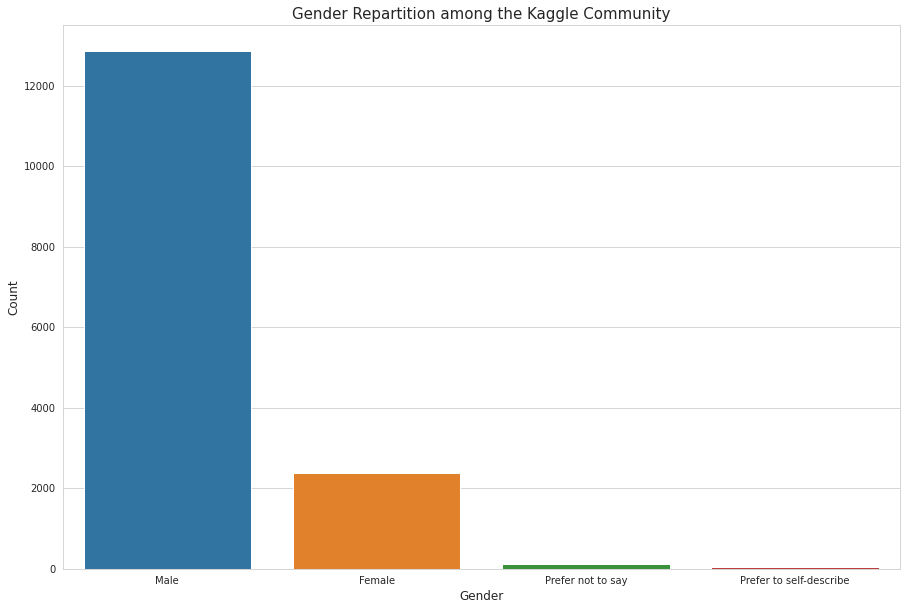

In [48]:
plt.figure(figsize = (15,10))
sns.countplot(data, x = "Q1")
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Gender Repartition among the Kaggle Community", fontsize=15)
plt.show()

In [61]:
data = data[data['Q1'] != "Prefer not to say"]
data = data[data['Q1'] != "Prefer to self-describe"]

### Distribution of Yearly Income of men/women in different countries

In [56]:
# converting ranges to median values
mapping = {'0-10,000': 5000, '10-20,000': 15000, '20-30,000': 25000, '30-40,000': 35000, 
       '40-50,000': 45000, '50-60,000': 55000, '60-70,000': 65000, '70-80,000': 75000, 
       '80-90,000': 85000, '90-100,000': 95000, '100-125,000': 112500, 
       '125-150,000': 137500, '150-200,000': 175000, '200-250,000': 225000, 
       '250-300,000': 275000, '300-400,000': 350000, '400-500,000': 450000, 
       '500,000+':500000}

data['target'] = data['Q9'].apply(lambda x: mapping[x])

In [57]:
country_dic = {'Morocco': 'Africa',
             'Tunisia': 'Africa',
             'Austria': 'Europe',
             'Hong Kong (S.A.R.)': 'Asia',
             'Republic of Korea': 'Asia',
             'Thailand': 'Asia',
             'Czech Republic': 'Europe',
             'Philippines': 'Asia',
             'Romania': 'Europe',
             'Kenya': 'Africa',
             'Finland': 'Europe',
             'Norway': 'Europe',
             'Peru': 'South America',
             'Iran, Islamic Republic of...': 'Middle East',
             'Bangladesh': 'Asia',
             'New Zealand': 'Oceania',
             'Egypt': 'Africa',
             'Chile': 'South America',
             'Belarus': 'Europe',
             'Hungary': 'Europe',
             'Ireland': 'Europe',
             'Belgium': 'Europe',
             'Malaysia': 'Asia',
             'Denmark': 'Europe',
             'Greece': 'Europe',
             'Pakistan': 'Asia',
             'Viet Nam': 'Asia',
             'Argentina': 'South America',
             'Colombia': 'South America',
             'Indonesia': 'Oceania',
             'Portugal': 'Europe',
             'South Africa': 'Africa',
             'South Korea': 'Asia',
             'Switzerland': 'Europe',
             'Sweden': 'Europe',
             'Israel': 'Middle East',
             'Nigeria': 'Africa',
             'Singapore': 'Asia',
             'I do not wish to disclose my location': 'dna',
             'Mexico': 'North America',
             'Ukraine': 'Europe',
             'Netherlands': 'Europe',
             'Turkey': 'Asia',
             'Poland': 'Europe',
             'Australia': 'Oceania',
             'Italy': 'Europe',
             'Spain': 'Europe',
             'Japan': 'Asia',
             'France': 'Europe',
             'Canada': 'North America', 
             'United Kingdom of Great Britain and Northern Ireland': 'Europe',
             'Germany': 'Europe',
             'Brazil': 'South America',
             'Russia': 'Russia',
             'Other': 'Other',
             'China': 'China',
             'India': 'India',
             'United States of America': 'USA'}

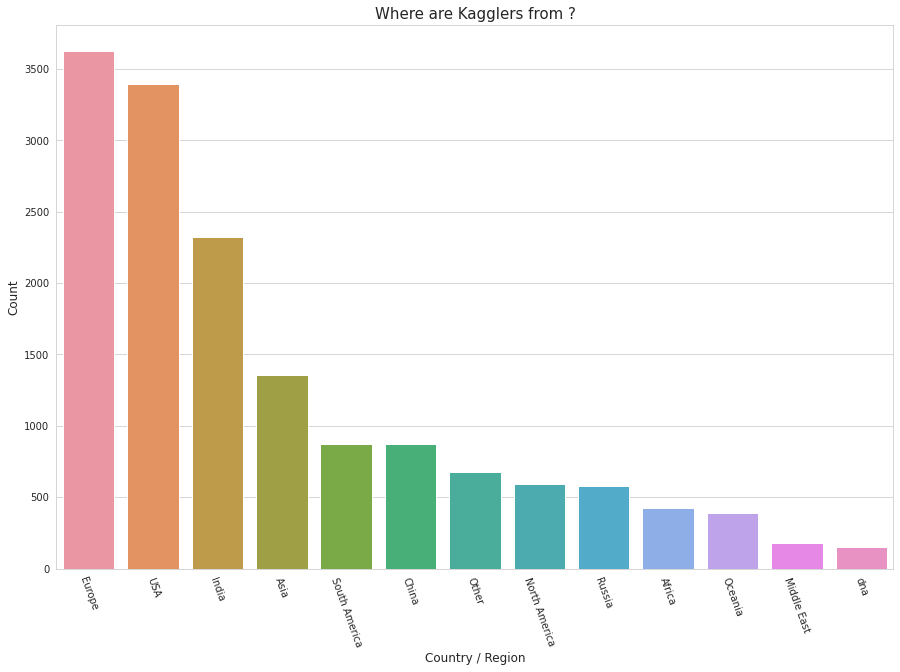

In [59]:
data['Q3'] = data['Q3'].apply(lambda x: country_dic[x])

# Distribution of people in different countries
plt.figure(figsize = (15,10))
sns.countplot(x = "Q3", data = data, order = data["Q3"].value_counts().index)
plt.xticks(rotation = -70)
plt.xlabel("Country / Region", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Where are Kagglers from ?", fontsize=15)
plt.show()

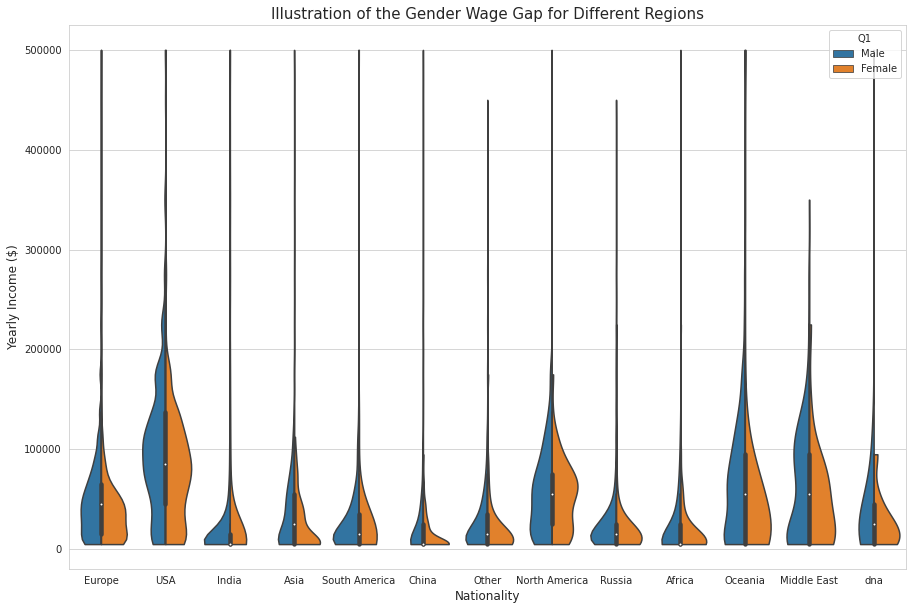

In [94]:
plt.figure(figsize = (15,10))
sns.violinplot(cut=0, x = 'Q3', y = 'target', hue = 'Q1', data = data, split=True, order = data['Q3'].value_counts().index)
plt.ylabel("Yearly Income ($)", fontsize=12)
plt.xlabel("Nationality", fontsize=12)
plt.title("Illustration of the Gender Wage Gap for Different Regions", fontsize=15)
plt.show()

### Distribution of men/women pay according to their educational qualification in different regions

In [70]:
unique_degrees = list(data["Q4"].unique())
print(unique_degrees)

['Bachelor’s degree', 'Master’s degree', 'Doctoral degree', 'Professional degree', 'Some college/university study without earning a bachelor’s degree', 'I prefer not to answer', 'No formal education past high school']


#### Bachelor's Degree

In [75]:
data["Q4"].unique()
bachelors = data[data["Q4"] == "Bachelor’s degree"]
print("Number of bachelors kagglers are {}".format(len(bachelors)))

Number of bachelors kagglers are 4339


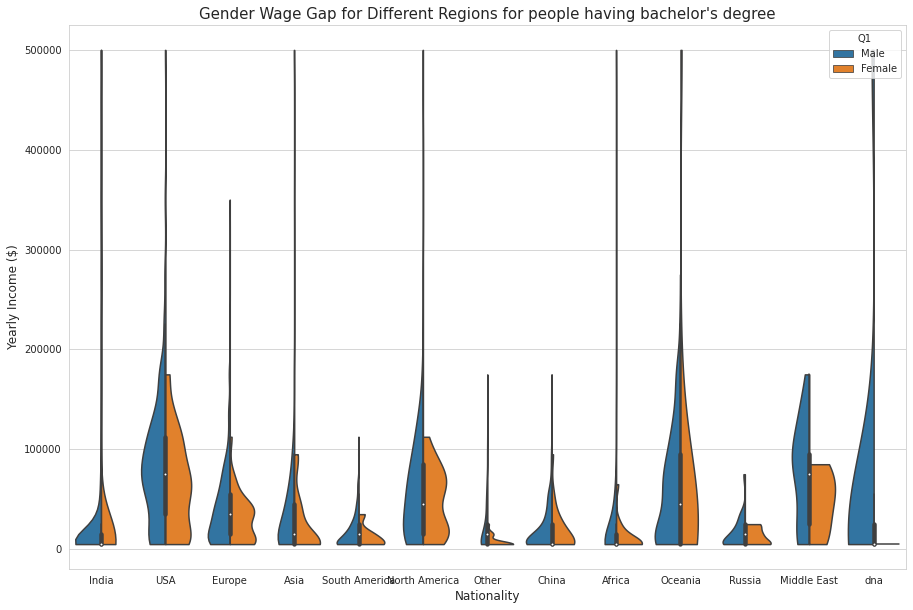

In [93]:
plt.figure(figsize = (15,10))
sns.violinplot(cut=0, x = 'Q3', y = 'target', hue = 'Q1', data = bachelors, split=True, order = bachelors['Q3'].value_counts().index)
plt.ylabel("Yearly Income ($)", fontsize=12)
plt.xlabel("Nationality", fontsize=12)
plt.title("Gender Wage Gap for Different Regions for people having bachelor's degree", fontsize=15)
plt.show()

#### Master's Degree

Number of masters kagglers are 7210


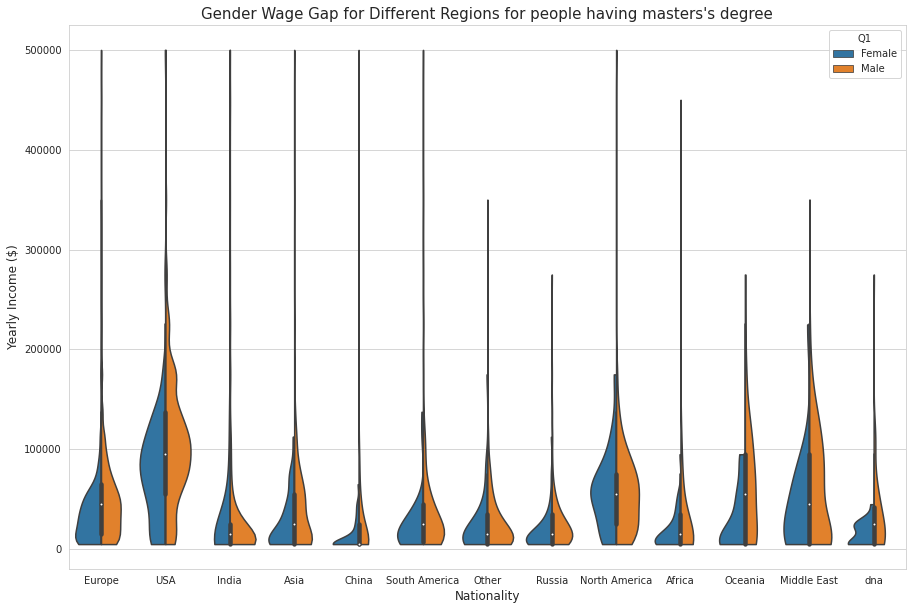

In [92]:
masters = data[data["Q4"] == "Master’s degree"]
print("Number of masters kagglers are {}".format(len(masters)))
plt.figure(figsize = (15,10))
sns.violinplot(cut = 0, x = 'Q3', y = 'target', hue = 'Q1', data = masters, split=True, order = masters['Q3'].value_counts().index)
plt.ylabel("Yearly Income ($)", fontsize=12)
plt.xlabel("Nationality", fontsize=12)
plt.title("Gender Wage Gap for Different Regions for people having masters's degree", fontsize=15)
plt.show()

## Analysing profession

In [78]:
professions = list(data["Q6"].unique())
print(professions)

['Other', 'Data Scientist', 'Data Analyst', 'Software Engineer', 'Student', 'Research Assistant', 'Chief Officer', 'Manager', 'Research Scientist', 'Business Analyst', 'Consultant', 'Data Engineer', 'Developer Advocate', 'Product/Project Manager', 'Marketing Analyst', 'Principal Investigator', 'Salesperson', 'DBA/Database Engineer', 'Statistician', 'Data Journalist']


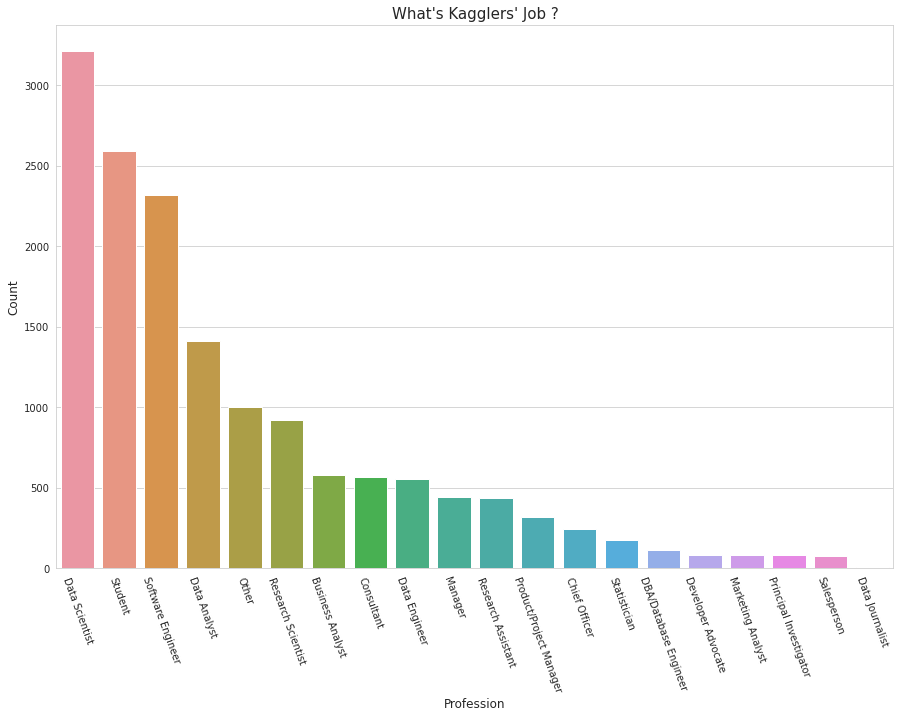

In [79]:
plt.figure(figsize=(15,10))
sns.countplot(data, x="Q6", order=data['Q6'].value_counts().index)
plt.xticks(rotation=-70)
plt.xlabel("Profession", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("What's Kagglers' Job ?", fontsize=15)
plt.show()

### Analysing the pay-gap of software engineers having bachelors and masters degree

928


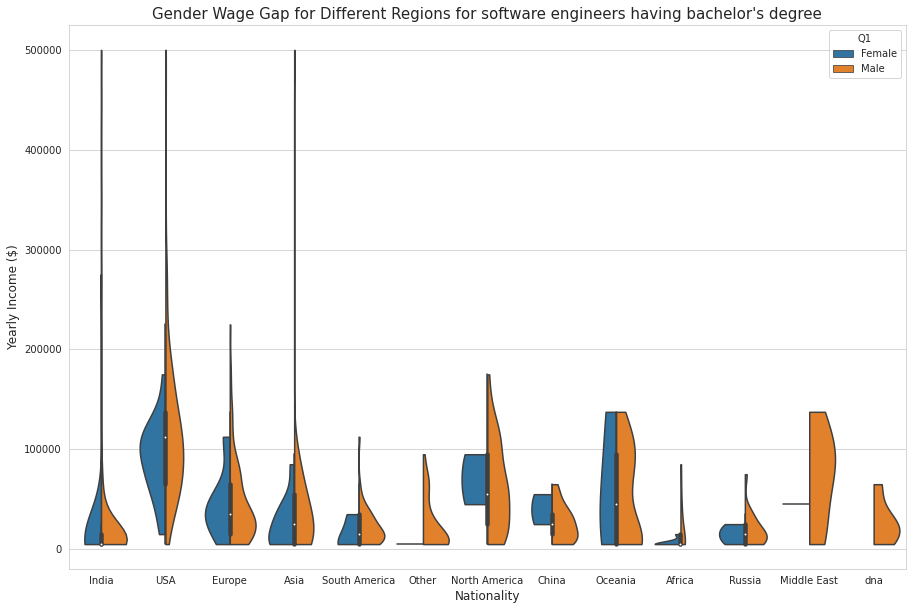

In [91]:
sw_eng = bachelors[bachelors["Q6"] == "Software Engineer"]
print(len(sw_eng))

plt.figure(figsize = (15,10))
sns.violinplot(cut=0, x = 'Q3', y = 'target', hue = 'Q1', data = sw_eng, split=True, order = sw_eng['Q3'].value_counts().index)
plt.ylabel("Yearly Income ($)", fontsize=12)
plt.xlabel("Nationality", fontsize=12)
plt.title("Gender Wage Gap for Different Regions for software engineers having bachelor's degree", fontsize=15)
plt.show()

In [89]:
sw_eng_neg = sw_eng[sw_eng["target"] == 0]
len(sw_eng_neg)

0

1009


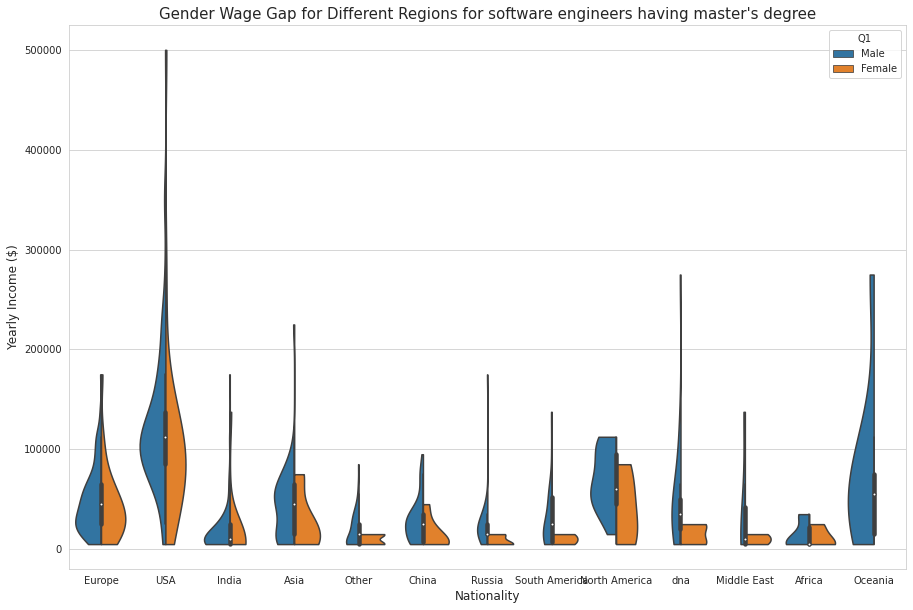

In [90]:
sw_eng_masters = masters[masters["Q6"] == "Software Engineer"]
print(len(sw_eng_masters))

plt.figure(figsize = (15,10))
sns.violinplot(cut = 0, x = 'Q3', y = 'target', hue = 'Q1', data = sw_eng_masters, split=True, order = sw_eng_masters['Q3'].value_counts().index)
plt.ylabel("Yearly Income ($)", fontsize=12)
plt.xlabel("Nationality", fontsize=12)
plt.title("Gender Wage Gap for Different Regions for software engineers having master's degree", fontsize=15)
plt.show()